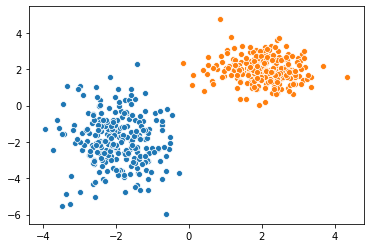

array([[-2.43257711,  0.29717124],
       [-2.75870339, -2.74694766],
       [-3.62743362, -0.77612879],
       [-2.53825456,  0.46753646],
       [-2.17633148, -1.54881058],
       [-3.45673947,  0.06773287],
       [-2.27156744, -2.45596678],
       [-2.77774057, -0.39660788],
       [-2.62073964, -2.24385031],
       [-1.58788741, -1.94030075],
       [-1.1905581 , -3.55651057],
       [-1.64468285, -0.72495818],
       [-2.48346861, -0.7259973 ],
       [-2.66168891, -2.17379302],
       [-1.62498205, -2.37885096],
       [-2.28054711, -2.97815602],
       [-2.59765064, -2.97180895],
       [-2.00895522, -2.94928538],
       [-1.83424307, -3.58011545],
       [-1.47529554,  0.34731475],
       [-2.62764846, -2.27129644],
       [-0.80325387, -3.05664139],
       [-2.45042394, -1.92814698],
       [-0.51489535, -1.73000473],
       [-1.5635715 , -1.83006958],
       [-2.24907826, -1.57549506],
       [-2.24702261, -3.61576473],
       [-1.58519476, -2.29542106],
       [-1.3416114 ,

In [2]:
# Mixture Model Example for ML w/ Prob Prog

from __future__ import absolute_import, division, print_function

import logging
import os

import pyro
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyro.distributions as distcc

import pyro.optim as optim
from torch.distributions import constraints
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive

%matplotlib inline

logging.basicConfig(format='%(message)s', level=logging.INFO)

assert pyro.__version__.startswith('0.4.1')
pyro.enable_validation(True)
pyro.set_rng_seed(1)

smoke_test = ('CI' in os.environ)

## Generating Data

_n = 250

data = list(np.random.multivariate_normal(
    [-2, -2],
    [
        [0.5, 0],
        [0, 2]
    ],
    _n
))
data += list(np.random.multivariate_normal(
    [+2, +2],
    [
        [0.5, 0],
        [0, 0.5]
    ],
    _n
))

data = np.array(data)

sns.scatterplot(x=data[:_n, 0], y=data[:_n, 1])
sns.scatterplot(x=data[_n:, 0], y=data[_n:, 1])

plt.show()
data


In [6]:
def create_model_obs(conn, weather=False):

    demand = get_demand(conn)
    censored = get_censored_demand(conn)

    model_data = demand.merge(censored,
                              on=['start_station_id', 'date_hour'],
                              how='left').fillna(0)

    if not weather:
        return model_data
    else:
        stations = get_station_info(conn)
        weather = get_weather()

        model_data = (model_data
                      .merge(stations[['id', 'zip_code']],
                             left_on='start_station_id',
                             right_on='id')
                      .merge(weather,
                             on=['zip_code', 'date'],
                             how='left'))
    return model_data

In [4]:
# bike data
import pandas as pd
from pandas.core.reshape.util import cartesian_product
import sqlite3
import pickle
import os
conn = sqlite3.connect('/Users/nihaar/Documents/Fall19/ML_Probabilistic_Programming_Columbia/code/data/sf_bikeshare.sqlite')
data_path = "/Users/nihaar/Documents/Fall19/ML_Probabilistic_Programming_Columbia/code/data/"
data = pd.read_pickle(data_path+"demand.pickle")

In [7]:
# data.loc["2013-08-29","demand"]
def get_station_info(conn):
    """Station specific information"""

    # Get all station info
    station_info = pd.read_sql_query("select * from station;", con=conn)
    station_info['installation_date'] = pd.to_datetime(
        station_info['installation_date'])

    # Get zip_code for station
    city_zip_mapping = pd.DataFrame(
        {
            'city': [
                'San Jose',
                'Redwood City',
                'Mountain View',
                'Palo Alto',
                'San Francisco'],
            'zip_code': [
                95113,
                94063,
                94041,
                94301,
                94107]})

    station_info = station_info.merge(city_zip_mapping)

    return station_info

stinfo= get_station_info(conn)


In [15]:
lat,lon = stinfo['lat'],stinfo['long']

70

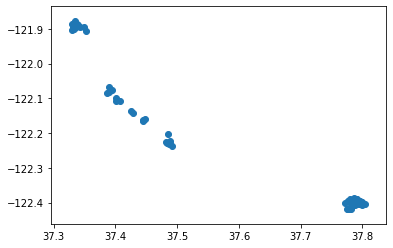

In [14]:
plt.scatter(lat,lon)

In [3]:
## Defining the Model

use_cuda = torch.cuda.is_available()

k = 2
alpha = 1
a, b = 1, 1

def model(data):
    global k, alpha, a, b
    global use_cuda
    
    pi = pyro.sample("pi", distcc.Dirichlet(alpha * torch.ones(k)))
    if use_cuda:
        pi = pi.cuda()
    
    with pyro.plate("components", k):
        mean = pyro.sample(
            "mean", distcc.MultivariateNormal(torch.zeros(2), torch.eye(2))
        )
        sigma = pyro.sample("sigma", distcc.InverseGamma(a, b))
        
        if use_cuda:
            mean = mean.cuda()
            sigma = sigma.cuda()
    
    with pyro.plate("data", len(data) if data is not None else _n*2):
        z = pyro.sample("lv", distcc.Categorical(pi))
        
        if use_cuda:
            z = z.cuda()
        
        _sigma = sigma[z].repeat(2, 2, 1).transpose(2, 0)
        
        if use_cuda:
            _sigma *= torch.eye(2).repeat(len(z), 1, 1).cuda()
        else:
            _sigma *= torch.eye(2).repeat(len(z), 1, 1)
                    
        obs = pyro.sample(
            "obs", distcc.MultivariateNormal(mean[z], _sigma), obs=data
        )
    
    return obs

def guide(data):
    global k, alpha, a, b
    global use_cuda
    
    pi = pyro.sample("pi", distcc.Dirichlet(alpha * torch.ones(k)))
    if use_cuda:
        pi = pi.cuda()
    
    with pyro.plate("components", k):
        mean = pyro.sample(
            "mean", distcc.MultivariateNormal(torch.zeros(2), torch.eye(2))
        )
        sigma = pyro.sample("sigma", distcc.InverseGamma(a, b))
        
        if use_cuda:
            mean = mean.cuda()
            sigma = sigma.cuda()
    
    with pyro.plate("data", len(data)):
        z = pyro.sample("lv", distcc.Categorical(pi))
        
        if use_cuda:
            z = z.cuda()

## SVI

data = torch.tensor(data, dtype=torch.float)
if use_cuda:
    data = data.cuda()
    
svi = SVI(model, 
          guide, 
          optim.Adam({"lr": .0001}),
          loss=Trace_ELBO(),
          num_samples=1000)

pyro.clear_param_store()
num_iters = 1000 if not smoke_test else 2
    
for i in range(num_iters):
    elbo = svi.step(data)
    if i % 50 == 0:
        logging.info("Elbo loss: {}".format(elbo))

posterior = svi.run(data)

sites = ["mean", "sigma", "pi"]

svi_samples = {
    site: EmpiricalMarginal(
        posterior, sites=site
    ).enumerate_support().detach().cpu().numpy()
    for site in sites
}

means = np.mean(svi_samples["mean"], 0)
print(means)

Elbo loss: 2334.92578125
Elbo loss: 3140.781005859375
Elbo loss: 2590.15478515625
Elbo loss: 5561.046875
Elbo loss: 6706.9619140625
Elbo loss: 4629.6591796875
Elbo loss: 2701.0517578125
Elbo loss: 2698.96728515625
Elbo loss: 2420.443603515625
Elbo loss: 3071.173583984375
Elbo loss: 3733.427490234375
Elbo loss: 3605.810791015625
Elbo loss: 2329.326904296875
Elbo loss: 2600.623046875
Elbo loss: 3332.0712890625


KeyboardInterrupt: 